<b> Explorar un único archivo <b>

In [1]:
import pandas as pd
from IPython.display import Image

df = pd.read_csv("./data_temp/EXP_1997.csv", sep = ";", index_col = 0)
df.head()

,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB
0,1997,2,82011000,10,63,RS,1,1015400,0,2384,5286
1,1997,2,85332110,11,756,SP,4,817600,56500,70,4062
2,1997,2,94035000,11,477,PA,1,217600,3,220,624
3,1997,1,25240010,10,845,GO,7,1010252,40,40000,13941
4,1997,1,73182900,10,249,SP,4,817600,0,0,122


<b> Detalles de Variables </b>

* CO_AND : Año
* CO_MES : Mes
* CO_NCM : Código HS
* CO_UNID : Código de unidad estadística
* CO_PAIS : Código del país de destino/origen del producto
* SG_UF_NCM : Códigos de unidades de la federación Brasileña (Estado/Distrito Federal)
* CO_VIA : Código de transporte
* CO_URF : Federal Revenue Unit
* KG_LIQUIDO : Kilogramo Líquido
* VL_FOB : FOB en dólares

<b> Dimensiones y Estructura </b>

En cada cubo se debe tener al menos dos dimensiones: Tiempo (Date) y Lugar (Geography), en el esquema de OEC, estas dimensiones pueden ser compartidas. Se debe apuntar a la siguiente estructura:

* date_id : Año + Mes
* product_id : Código HS
* country_id : Código de país
* state_id : Códigos de estado(distrito federal)
* transport_id : Código de transporte
* fob : Valor de FOB en dólares

Por simplicidad, se omiten otras columnas.

<b> Transformación </b>

In [2]:
df["date_id"] = df["CO_ANO"].astype("str") + "-" + df["CO_MES"].astype("str").str.zfill(2)
df = df.drop(columns = {"CO_ANO","CO_MES", "CO_UNID", "CO_URF", "KG_LIQUIDO", "QT_ESTAT"})

df = df.rename(columns = {"CO_NCM": "product_id", "CO_PAIS": "country_id", "SG_UF_NCM": "state_id", 
                          "CO_VIA": "transport_id", "VL_FOB": "fob"})

df = df[["date_id", "product_id", "country_id", "state_id", "transport_id", "fob"]]

states = pd.read_csv("http://www.mdic.gov.br/balanca/bd/tabelas/UF.csv", sep = ";", encoding="latin-1")
states = dict(zip(states["SG_UF"], states["CO_UF"]))

df["state_id"] = df["state_id"].map(states)

df.head()

,date_id,product_id,country_id,state_id,transport_id,fob
0,1997-02,82011000,63,45,1,5286
1,1997-02,85332110,756,41,4,4062
2,1997-02,94035000,477,15,1,624
3,1997-01,25240010,845,53,7,13941
4,1997-01,73182900,249,41,4,122


<b> Creación de Tablas de Dimensión <b>

In [3]:
date_table = pd.DataFrame({"date": pd.date_range("1997", "2020", freq="M")})
date_table["date_id"] = date_table.date.dt.year.astype(str) + "-" + date_table.date.dt.month.astype(str).str.zfill(2)
date_table["year"] = date_table.date.dt.year
date_table["quarter"] = date_table.date.dt.year.astype(str) + "-Q" + date_table.date.dt.quarter.astype(str)
date_table["month_en"] = date_table.date.dt.month_name()
date_table["month"] = date_table.date.dt.year.astype(str) + " " + date_table["month_en"]
date_table.to_csv("./dimension_tables/date_table.csv", index = False)
date_table.head()

,date,date_id,year,quarter,month_en,month
0,1997-01-31,1997-01,1997,1997-Q1,January,1997 January
1,1997-02-28,1997-02,1997,1997-Q1,February,1997 February
2,1997-03-31,1997-03,1997,1997-Q1,March,1997 March
3,1997-04-30,1997-04,1997,1997-Q2,April,1997 April
4,1997-05-31,1997-05,1997,1997-Q2,May,1997 May


In [4]:
product_table = pd.read_csv("http://www.mdic.gov.br/balanca/bd/tabelas/NCM.csv", sep = ";", encoding = "latin-1")
product_table = product_table.rename(columns = {"CO_NCM": "product_id"})
product_table.to_csv("./dimension_tables/product_table.csv", index = False)
product_table.head()

,product_id,CO_UNID,CO_SH6,CO_PPE,CO_PPI,CO_FAT_AGREG,CO_CUCI_ITEM,CO_CGCE_N3,CO_SIIT,CO_ISIC4,CO_EXP_SUBSET,NO_NCM_POR,NO_NCM_ESP,NO_NCM_ING
0,29398000,10,293980,3329,3329,3,54149,240,1000,21,1402.0,"Outros alcalóides, naturais ou reproduzidos po...","Otros alcaloides, naturales o producidas por s...","Other alkaloids, natural or produced by synthe..."
1,30021100,10,300211,3990,3221,3,54163,322,1000,21,1406.0,Estojos de diagnóstico da malária (paludismo),Kits de diagnóstico de malaria,Diagnostic kits to detect malaria
2,30021211,10,300212,3990,3990,3,54163,322,1000,21,1406.0,Antiofídicos e outros antivenenosos,Antiofídicos y otros antivenenosos,Antiophidic and other anti poisons
3,30021212,10,300212,3990,3990,3,54163,322,1000,21,1406.0,Antitetânico,Antitetánica,Antitetanus
4,30021213,10,300212,3990,3990,3,54163,322,1000,21,1406.0,Anticatarral,Anticatarral,Anticatarrhal


In [5]:
country_table = pd.read_csv("http://www.mdic.gov.br/balanca/bd/tabelas/PAIS.csv", sep = ";", encoding = "latin-1")
country_table = country_table.rename(columns={"CO_PAIS": "country_id"})
country_table.to_csv("./dimension_tables/country_table.csv", index = False)
country_table.head()

,country_id,CO_PAIS_ISON3,CO_PAIS_ISOA3,NO_PAIS,NO_PAIS_ING,NO_PAIS_ESP
0,0,898,ZZZ,Não Definido,Not defined,No definido
1,13,4,AFG,Afeganistão,Afghanistan,Afganistan
2,15,248,ALA,"Aland, Ilhas",Aland Islands,"Alans, Islas"
3,17,8,ALB,Albânia,Albania,Albania
4,20,724,ESP,"Alboran-Perejil, Ilhas","Alboran-Perejil, Islands","Alboran-Perejil, Islas"


In [6]:
state_table = pd.read_csv("http://www.mdic.gov.br/balanca/bd/tabelas/UF.csv", sep = ";", encoding = "latin-1")
state_table = state_table.rename(columns={"CO_UF": "state_id"})
state_table.to_csv("./dimension_tables/state_table.csv", index = False)
state_table.head()

,state_id,SG_UF,NO_UF,NO_REGIAO
0,11,RO,Rondônia,REGIAO NORTE
1,12,AC,Acre,REGIAO NORTE
2,13,AM,Amazonas,REGIAO NORTE
3,14,RR,Roraima,REGIAO NORTE
4,15,PA,Pará,REGIAO NORTE


In [7]:
transport_table = pd.read_csv("http://www.mdic.gov.br/balanca/bd/tabelas/VIA.csv", sep = ";", encoding = "latin-1")
transport_table = transport_table.rename(columns={"CO_VIA": "transport_id"})
transport_table.to_csv("./dimension_tables/transport_table.csv", index = False)
transport_table.head()

,transport_id,NO_VIA
0,99,VIA DESCONHECIDA
1,10,ENTRADA/SAIDA FICTA
2,0,VIA NAO DECLARADA
3,1,MARITIMA
4,2,FLUVIAL


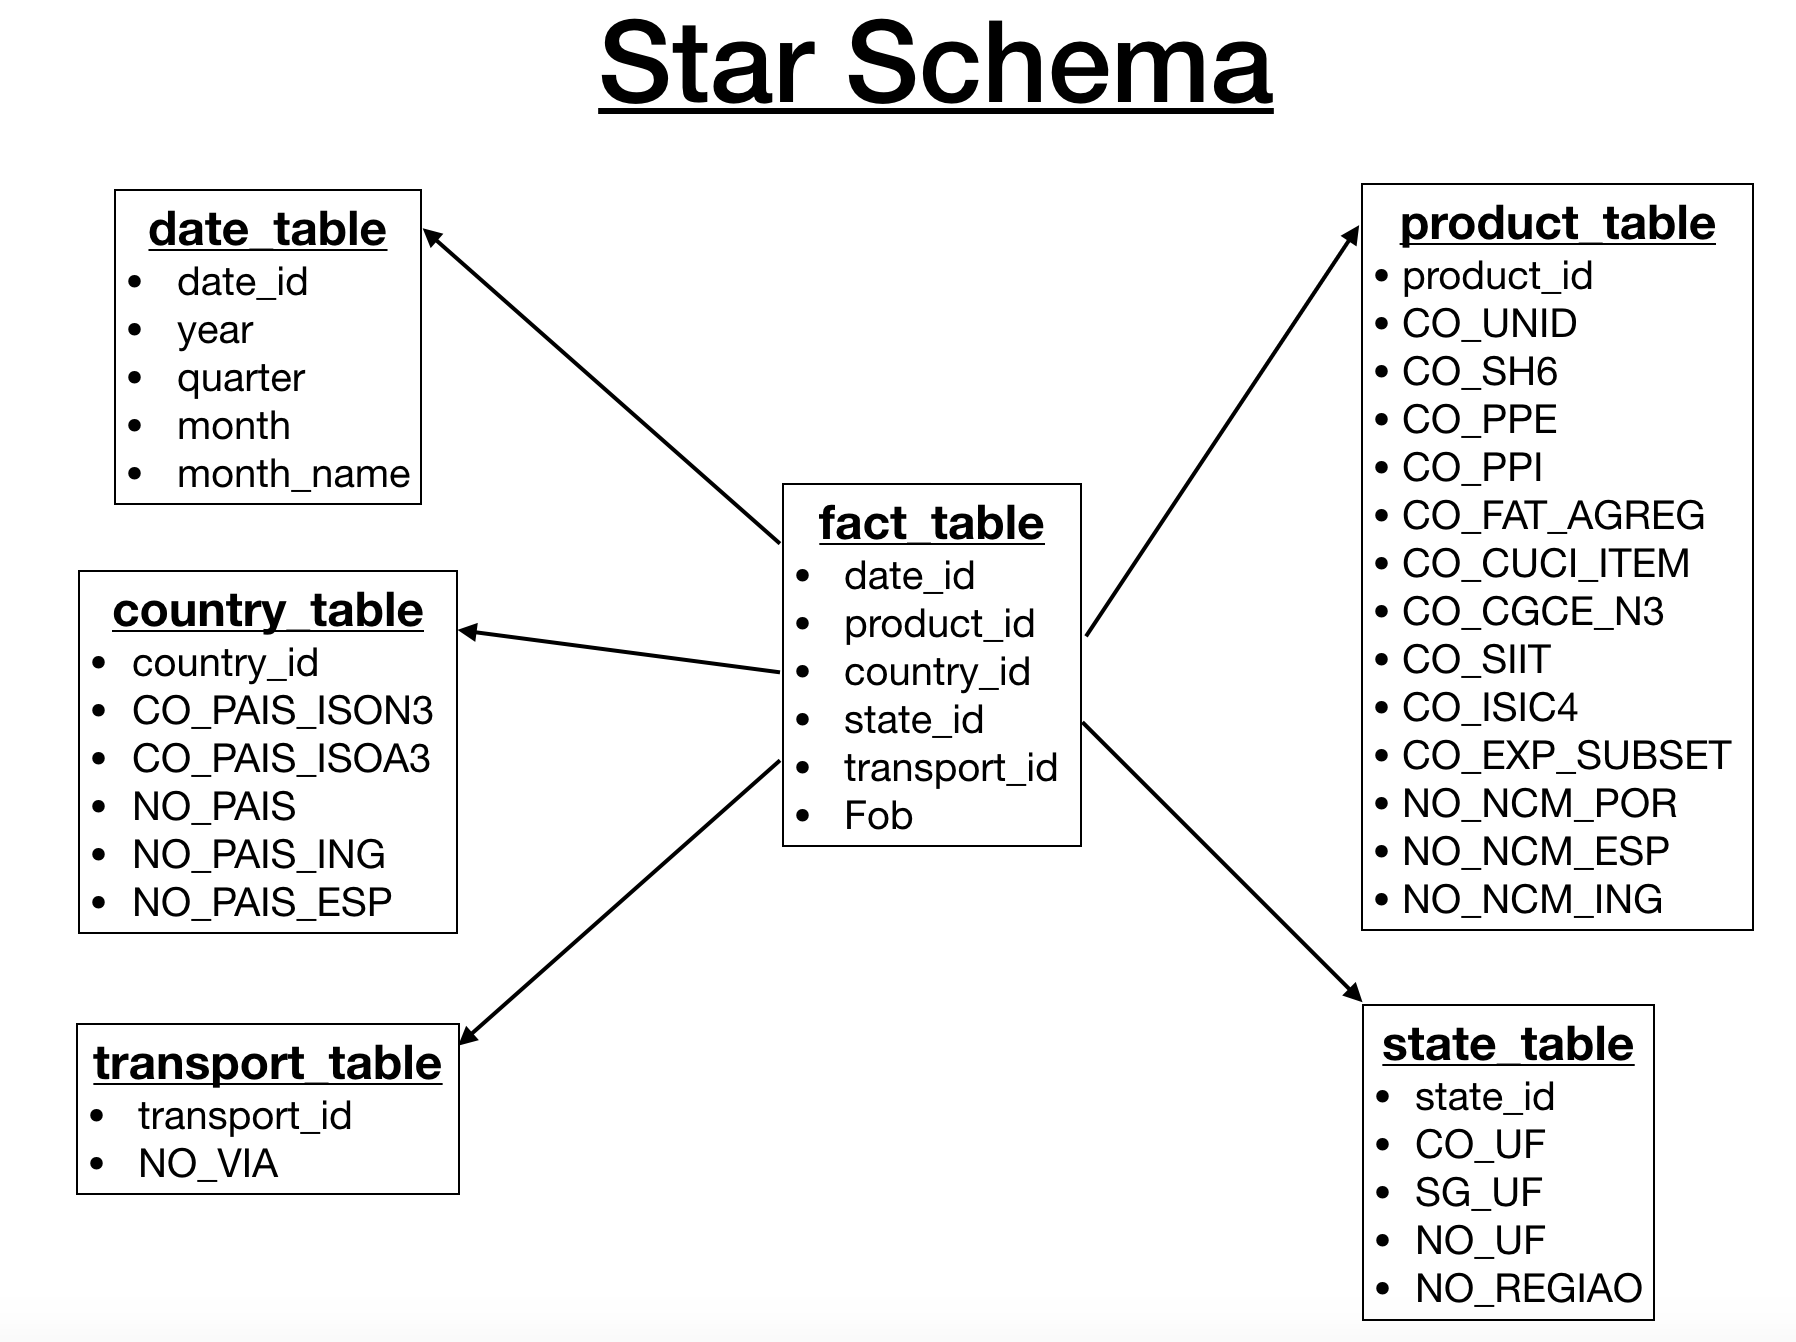

In [8]:
Image("star_schema.png", width = 800)

<b> Scripts a diseñar </b>
* **ncm_pipeline.py** : Para procesar e ingestar un año de datos en la base de datos.
* **dim_pipeline.py** : Para cargar cada tabla de dimensión y ingestarla en la base de datos.
* **cli_pipeline.py** : Script que aprovecha bamboo-cli para ingestar en la base de datos todas las tablas de dimensión y todos los años (1997-2019) en la base de datos.